In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model, load_model

# To import 'katakana' from relative path
#sys.path.append(os.path.abspath(os.path.join('..')))
import encoding

INPUT_LENGTH = 90
OUTPUT_LENGTH = 90

In [2]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data pre-processing

In [3]:
data = pd.read_csv('../datasets/hospital_augment_train3.csv')
data = data.sample(frac=1, random_state=0)

data_input = list(data['gen_data'])
data_output =  list(data['true_data'])
print(data_input[0], data_output[0])
print(data_input[5], data_output[5])

data_size = len(data)
a = int(data_size*90/100)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[:a]
training_output = data_output[:a]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[a:]
validation_output = data_output[a:]

print('training size', len(training_input))
print('validation size', len(validation_input))

โรงพยาบาลโนนสูง โรงพยาบาลโนนสูง
โรงพยาบฯลโนนศิลา โรงพยาบาลโนนศิลา
training size 27864
validation size 3097


In [4]:
data_output[0]

'โรงพยาบาลโนนสูง'

### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [5]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('Input character dict size:', input_dict_size)
print('Output character dict size:', output_dict_size)


encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

Input character dict size: 93
Output character dict size: 83
encoded_training_input (27864, 90)
encoded_training_output (27864, 90)
encoded_validation_input (3097, 90)
encoded_validation_output (3097, 90)


# Sequence-to-Sequence in Keras

In [6]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [7]:
  
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [8]:
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Attention,RepeatVector,Input,concatenate,TimeDistributed,Dropout

### Encoder / Decoder

In [9]:
from tensorflow.keras.layers import SimpleRNN,Bidirectional,Concatenate
#from keras.layers.attention import AttentionLayer

latent_dim = 128
# Encoder
encoder_inputs = Input(shape=(INPUT_LENGTH,))
encoder_emb = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH,mask_zero=True)

encoder_lstm = Bidirectional(LSTM(units=latent_dim, return_sequences=True, return_state=True)) # Bidirectional

encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])

encoder_states = [state_h, state_c]

In [10]:
#decoder_inputs = Input(shape=(None,))
#decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=output_dict_size, output_dim=64)
decoder_lstm = LSTM(units=latent_dim*2, return_sequences=True, return_state=True) # units=units*2
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_input), initial_state=encoder_states)

In [11]:
encoder_out.shape,decoder_lstm_out.shape

(TensorShape([None, 90, 256]), TensorShape([None, 90, 256]))

In [12]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_out, decoder_lstm_out])

In [13]:
# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_lstm_out, attn_out])

In [14]:
# Two dense layers
dense = Dense(output_dict_size, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_concat_input)

### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [15]:
model = Model(inputs = [encoder_inputs, decoder_input], outputs= decoder_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 64)       5952        input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 90, 256), (N 197632      embedding[0][0]                  
______________________________________________________________________________________________

## Training the model

In [17]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [36]:
'''
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30)
'''
hist = model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          batch_size=64, epochs=20)

#model.save('model_v2.h5')

Train on 27864 samples, validate on 3097 samples
Epoch 1/20
27864/27864 [==============================] - 212s 8ms/sample - loss: 0.7690 - val_loss: 0.4729
Epoch 2/20
27864/27864 [==============================] - 177s 6ms/sample - loss: 0.4207 - val_loss: 0.3629
Epoch 3/20
27864/27864 [==============================] - 177s 6ms/sample - loss: 0.3132 - val_loss: 0.2529
Epoch 4/20
27864/27864 [==============================] - 176s 6ms/sample - loss: 0.2018 - val_loss: 0.1455
Epoch 5/20
27864/27864 [==============================] - 175s 6ms/sample - loss: 0.0933 - val_loss: 0.0620
Epoch 6/20
27864/27864 [==============================] - 107s 4ms/sample - loss: 0.0402 - val_loss: 0.0308
Epoch 7/20
27864/27864 [==============================] - 115s 4ms/sample - loss: 0.0250 - val_loss: 0.0237
Epoch 8/20
 1408/27864 [>.............................] - ETA: 1:51 - loss: 0.0206

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

NameError: name 'hist' is not defined

In [338]:
encoder_input.shape

TensorShape([None, 90])

In [339]:
encoder_model = Model(encoder_input,encoder_states)

In [340]:
state_input_h = Input(shape=(units*2,), name="state_input_h") # units*2 if Bidirectional LSTM else units*1
state_input_c = Input(shape=(units*2,), name="state_input_c") # units*2
inf_decoder_inputs = Input(shape=(INPUT_LENGTH, units*2), name="inf_decoder_inputs")
# similar decoder model architecture with state from encoder model
decoder_res, decoder_h, decoder_c = decoder_lstm(decoder_emb(decoder_input),
                                                 initial_state=[state_input_h, state_input_c])

In [341]:
inf_decoder_inputs.shape,decoder_res.shape

(TensorShape([None, 90, 128]), TensorShape([None, 90, 128]))

In [342]:
# Attention inference
attention = dot([inf_decoder_inputs, decoder_res], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
context = dot([attention, encoder_out], axes=[2,1])
# Concat attention input and decoder LSTM output
decoder_out_concat_res = Concatenate(axis=-1, name='concat_layer')([decoder_res, context])

In [348]:
decoder_input.shape,inf_decoder_inputs.shape

(TensorShape([None, 90]), TensorShape([None, 90, 128]))

In [350]:
state_input_c.shape,state_input_c.shape

(TensorShape([None, 128]), TensorShape([None, 128]))

In [356]:

decoder_d1 = TimeDistributed(Dense(units, activation="relu"))
decoder_d2 = TimeDistributed(Dense(output_dict_size, activation="softmax"))
inf_decoder_out = decoder_d2(decoder_d1(decoder_out_concat_res))
# finalizing the deocder model

inf_model = Model(inputs=([decoder_input] + [inf_decoder_inputs,  state_input_h, state_input_c]), 
                  outputs=[inf_decoder_out, decoder_h, decoder_c], name = 'Decoder')


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_7:0", shape=(None, 90), dtype=float32) at layer "input_7". The following previous layers were accessed without issue: ['input_8', 'embedding_9', 'state_input_h', 'state_input_c', 'lstm_9']

In [354]:
 b= [decoder_input]+[inf_decoder_inputs,  state_input_h, state_input_c]

[<tf.Tensor 'input_8:0' shape=(None, 90) dtype=float32>,
 <tf.Tensor 'inf_decoder_inputs_6:0' shape=(None, 90, 128) dtype=float32>,
 <tf.Tensor 'state_input_h_6:0' shape=(None, 128) dtype=float32>,
 <tf.Tensor 'state_input_c_6:0' shape=(None, 128) dtype=float32>]

In [239]:
decoder_input.shape,inf_decoder_inputs.shape

(TensorShape([None, 90]), TensorShape([None, 90, 128]))

### Testing the model


In [21]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    text_list =[]
    for i in sequence:
        if i != 0:
            text += output_decoding[i]
            text_list.append(output_decoding[i])
    return text,text_list

def to_katakana(text):
    decoder_output = generate(text)
    txt,lst = decode(output_decoding, decoder_output[0])
    return txt,lst

In [22]:
k=data_input[:10]

In [290]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

In [305]:
text = k[0]

In [421]:
encoder_input = encoding.transform(input_encoding, [text], 90)
decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
decoder_input[:,0] = encoding.CHAR_CODE_START

In [422]:
a= [encoder_input, decoder_input]

In [423]:
a

[array([[73, 48, 34, 36, 17, 22, 93, 22, 43, 93, 49, 22, 63, 83, 36, 49,
         46, 14, 22, 26, 22, 36, 48, 49, 41, 70, 70, 85, 57, 48,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [45]:
pred_out =[]
for name in k:
    a,b =to_katakana(name)
    print(name, a)
    pred_out.append(to_katakana(name))

โรงพยาบาลป2างศิลาทอง โรงพยบบลลปาแทอ
โรงพยาบาลบ่อทอ6ง โรงพยบบลล้อัทอ
โรงพยาบาลชพิมาย โรพพยายลลเชย
โรงพยาบาลทรมายมูล โรพพยบบลลไหลล์
.รงพยาบาลทุ่งเขาหลวง โรพพยบบลลแ้งไหห้อ
โรงพยาบาลพรหมพิาม โรพพยบบลลพคหิา
โรงพาบาลท่าศาลา โรรพยาาลลไ่ลทา
โรงพยาบาซยะหริ่ง โรพพยาบลลแ้ก่ช
โรงพยาบาลนายแพท์หาญ โรงพยบบลลนแนแยย
โรง๊ยาบาลน้ำปาด โรพพยบบลลนแน


In [426]:
data_test = pd.read_csv('../datasets/hospital_augment_test6_3.csv', header=None)

In [427]:
data_input_test = [s for s in data_test[0]]
data_output_test = [s for s in data_test[1]]

In [428]:
for i in range(10):
    a,b =to_katakana(data_input_test[i])
    out = data_output_test[i]
    print(data_input_test[i],'>', a,'>',out)

gen_data > ttttธรผ2 > true_data
คลินิกกรุงเ3ทพพัทยาสาขาจอมเทียน > คินิิกรกุพพะอสเพยยยสอ > คลินิกกรุงเทพพัทยาสาขาจอมเทียน
คลินิชกกุงเทพระยองส"าขาบ่อวิน > คคิิกรกรุเโยยรยสพ(อสุวไย > คลินิกกรุงเทพระยองสาขาบ่อวิน
คลินิกชรุงเทพระยองสาขาปลวกแดง > คิิิ์รรพยสเยยสลแุอ > คลินิกกรุงเทพระยองสาขาปลวกแดง
คลินิกไท์ยอินเตอร์การแพ&ยท(เกาะพงัน) > คิิิิศไไยร(ิรยรนรศอ > คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)
คลินิกรักสโขภาพจ.ระยอง > คิิิิรร.ัไ ยรพยย > คลินิกรักสุขภาพจ.ระยอง
คลินิกโรงพยาบาลกรุงเทพพัทยฮาสาขานาเ"ลโือ > คาน์โอเยันุ > คลินิกโรงพยาบาลกรุงเทพพัทยาสาขานาเกลือ
คลินิกโรงทยาบาลกรุงเทพพัทยาสาขาบุญสัมพันธ์ > คิิิิิรรพพไพยยาัยาัาุสเยุุพ > คลินิกโรงพยาบาลกรุงเทพพัทยาสาขาบุญสัมพันธ์
คลินิกโงพยาบาลกร6ุงเทพสม"ุย > คิิิิิรรพพพยยบลยสเกรย > คลินิกโรงพยาบาลกรุงเทพสมุย
คลินิกโรงพฒญาบาลสมิติเวชศรีราชา(อีส3เทิร์นซีบอร์ด) > คิิิิรรรพ ยยพ าเยรเยเ(อ > คลินิกโรงพยาบาลสมิติเวชศรีราชา(อีสเทิร์นซีบอร์ด)


In [191]:
t1 = generate(text)

In [192]:
t1

array([[65., 31., 65., 65., 65., 65.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [240]:
encoder_input = encoding.transform(input_encoding, [text], 90)
decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
#decoder_input2 = encoding.transform(output_encoding,[text],90)
decoder_input[:,0] = encoding.CHAR_CODE_START

In [246]:
for i in range(1, OUTPUT_LENGTH):
    output = model.predict([encoder_input, decoder_input])
    idx = output.argmax(axis=2)
    decoder_input[:,i] = idx[:,i]
    a = idx[:,i]
    print(output_decoding[a[0]])

โ
ี
อ
ี
ท
อ
ร
ี
อ
ี
แ
ท
ร
ฐ
ร
ท
ฎ
ฎ
๋
ู
ี
ท
8
ท
้
ท
ฎ
ต
ู
ู
ต
ค
ู
ต
a
ฎ
7
้
ี
)
ะ
อ
ี
ท
ร
ท
ฎ
ต
ฎ
ฆ
ู
ต
ค
ต
ั
ผ
ต
ผ
ะ
ฬ
ฬ
ค
้
ต
ู
ต
ค
a
ู
ี
ท
ฎ
ฎ
๋
ต
ณ
ั
ฬ
ฬ
ต
ฬ
ค
ะ
ต
ค
์
น
ท
ค


In [245]:
output_decoding[85]

'ฝ'

In [66]:
x1= np.reshape(training_encoder_input[9,:],(1,90))
x2= np.reshape(training_decoder_input[9,:],(1,90))

In [68]:
out  =model.predict([x1,x2])

In [69]:
idx = out.argmax(axis=2)

In [70]:
lst = []
for i in range(idx.shape[1]):
    a = idx[0,i]
    if a != 0:
        lst.append(output_decoding[a])

In [71]:
''.join(lst[1:])

'คลินิกกรุงเทพระยองสาขาบ้านฉาง'

In [429]:
result = model.predict([training_encoder_input,training_decoder_input])

In [430]:
index_result = result.argmax(axis=2)

In [122]:
index_result.shape

(77137, 90)

In [431]:
lst_output =[]
for i in range(10000):
    temp = []
    for j in range(index_result.shape[1]):
        a = int(index_result[i,j])
        if a != 0:
            temp.append(output_decoding[a])
    lst_output.append(temp[1:])

In [432]:
### Input, Predict, Target ###
pred_sent = []
count = 0
for i in range(1000):
    print(data_input[i],'>', ''.join(lst_output[i]), '>', data_output[i])
    a = data_output[i]
    pred_sent.append(''.join(lst_output[i]))
    if str(''.join(lst_output[i])) == a[1:]:
        count +=1

องเลยราม
โรงพยาๆาลหลวงพ่ทวีศักดิ์ ชุผินธโร อุทิ > โรงพยาบาลหลวงพ่อทวีศักดิ์ ชุตินธโร อุทิศ > 	โรงพยาบาลหลวงพ่อทวีศักดิ์ ชุตินธโร อุทิศ
สหคลินิกกลว้ยน้าไท้าขาราม2 > สหคลินิกกล้วยน้ำไทสาขาราม2 > 	สหคลินิกกล้วยน้ำไทสาขาราม2
โรงพยาบาลมหาชัย2 > โรงพยาบาลมหาชัย2 > 	โรงพยาบาลมหาชัย2
โรูพยาบาลเชียงดาว > โรงพยาบาลเชียงดาว > 	โรงพยาบาลเชียงดาว
โรงพยาบาลศรีสมเด็ > โรงพยาบาลศรีสมเด็จ > 	โรงพยาบาลศรีสมเด็จ
โรงพยาบาลหริภุญชัยเฝมโมเรียล > โรงพยาบาลหริภุญชัยเมโมเรียล > 	โรงพยาบาลหริภุญชัยเมโมเรียล
โรงพยาบาลเกะคา > โรงพยาบาลเกาะคา > 	โรงพยาบาลเกาะคา
โรงพยาบาลกงไกรฺาศ > โรงพยาบาลกงไกรลาศ > 	โรงพยาบาลกงไกรลาศ
โรงพยาบาลสองพฺ่น้4อง > โรงพยาบาลสองพี่น้อง > 	โรงพยาบาลสองพี่น้อง
โรงขพยาบาลพระปกเกล้า > โรงพยาบาลพระปกเกล้า > 	โรงพยาบาลพระปกเกล้า
โรงฌยาบาลบางบ่อ > โรงพยาบาลบางบ่อ > 	โรงพยาบาลบางบ่อ
โรงพยาบาลถนาตาล > โรงพยาบาลนาตาล > 	โรงพยาบาลนาตาล
โรงพาบาลเปาโลเมโมเรียล > โรงพยาบาลเปาโลเมโมเรียล > 	โรงพยาบาลเปาโลเมโมเรียล
โรงพย)บาลหนองเรือ > โรงพยาบาลหนองเรือ > 	โรงพยาบาลหนองเรือ
โรงพยาบาลโนนไทย > โรงพยาบาลโนนไ

In [173]:
pred_sent[555],data_output[555]

('โรงพยาบาลภูกาง', '\tโรงพยาบาลภูซาง')

In [441]:
text = 'โรงพยาบาลพานทอง'

In [442]:
to_katakana(text)

('โรพพาาาลพพไท', ['โ', 'ร', 'พ', 'พ', 'า', 'า', 'า', 'ล', 'พ', 'พ', 'ไ', 'ท'])

In [180]:
encoded_training_output_sample = encoding.transform(
    output_encoding, [text] ,vector_size=OUTPUT_LENGTH)

In [182]:
encoded_training_output_sample.shape

(1, 90)

In [183]:
encoded_training_output.shape

(77137, 90)

In [90]:
decoder_input[:,0] = encoding.CHAR_CODE_START

In [96]:
output = model.predict([encoder_input, decoder_input]).argmax(axis=2)

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [73]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[9] == model.get_layer('attention'))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000238DF371088>	name:input_1
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002388A170748>	name:embedding
<tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x00000238DF371908>	name:bidirectional
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000238DF371048>	name:input_2
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002388A16CC08>	name:embedding_1
<tensorflow.python.keras.layers.merge.Concatenate object at 0x000002388A17E488>	name:concatenate
<tensorflow.python.keras.layers.merge.Concatenate object at 0x000002388A170D08>	name:concatenate_1
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000002388A16CBC8>	name:lstm_1
<tensorflow.python.keras.layers.merge.Dot object at 0x000002389170D808>	name:dot
<tensorflow.python.keras.layers.core.Activation object at 0x00000238916FF148>	name:attention
<tensorflow.python.keras.layers.merge.Do

We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [74]:
attention_layer = model.get_layer('attention') # or model.layers[7]
#attention_layer = model.layers[8]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 90, 91), (None, 90, 90)]


In [440]:
model

In [133]:
output, attention,weight=attention_model.predict([encoder_input, decoder_input])

In [433]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn
#plt.rcParams

seaborn.set(font=['Tahoma'], font_scale=1)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(20,10))
    ax = seaborn.heatmap(attention_density[:len(katakana[0]), :len(text)+1],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana[0]])

    ax.invert_yaxis()
    plt.show()


<Figure size 432x288 with 0 Axes>

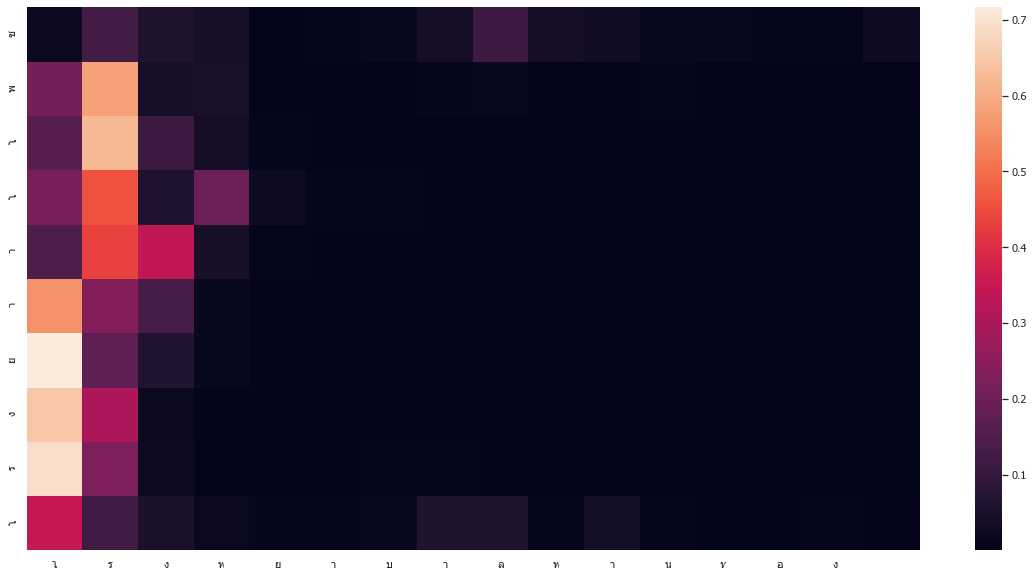

In [436]:
visualize('โรงพยาบาลพานทอง')